In [2]:
%store -r

In [4]:
import xarray as xr

path = "/Volumes/ct_data/carbon_tracker_ocean/CT2025.molefrac_glb3x2_2024-01-04.nc"
ds = xr.open_dataset(path)

ds


<xarray.Dataset> Size: 95MB
Dimensions:              (time: 8, level: 34, latitude: 90, longitude: 120,
                          boundary: 35, calendar_components: 6)
Coordinates:
  * time                 (time) datetime64[ns] 64B 2024-01-04T01:30:00 ... 20...
  * level                (level) int32 136B 1 2 3 4 5 6 7 ... 29 30 31 32 33 34
  * latitude             (latitude) float64 720B -89.0 -87.0 -85.0 ... 87.0 89.0
  * longitude            (longitude) float64 960B -178.5 -175.5 ... 175.5 178.5
  * boundary             (boundary) int32 140B 1 2 3 4 5 6 ... 30 31 32 33 34 35
  * calendar_components  (calendar_components) int32 24B 1 2 3 4 5 6
Data variables: (12/13)
    air_mass             (time, level, latitude, longitude) float32 12MB ...
    blh                  (time, latitude, longitude) float32 346kB ...
    co2                  (time, level, latitude, longitude) float32 12MB ...
    decimal_date         (time) float64 64B ...
    gph                  (time, boundary, latitude, longitude) float32 12MB ...
    orography            (latitude, longitude) float32 43kB ...
    ...                   ...
    pressure             (time, boundary, latitude, longitude) float32 12MB ...
    specific_humidity    (time, level, latitude, longitude) float32 12MB ...
    temperature          (time, level, latitude, longitude) float32 12MB ...
    time_components      (time, calendar_components) int32 192B ...
    u                    (time, level, latitude, longitude) float32 12MB ...
    v                    (time, level, latitude, longitude) float32 12MB ...
Attributes:
    notes:        This file contains CarbonTracker mole fractions averaged ov...
    disclaimer:   CarbonTracker is an open product of the NOAA Global Monitor...
    email:        carbontracker.team@noaa.gov
    url:          http://carbontracker.noaa.gov
    institution:  NOAA Global Monitoring Laboratory
    conventions:  CF-1.5
    history:      Created 2025-07-11 22:03:16 UTC by ./p8rf.ml137.orion.x.
    version:      CarbonTracker release version CT2025 - mole fraction output...

In [5]:
import numpy as np
import xarray as xr
from shapely.ops import unary_union
from shapely.vectorized import contains

# 1. open a CT file (single file for now)
path = "/Volumes/ct_data/carbon_tracker_ocean/CT2025.molefrac_glb3x2_2024-01-04.nc"
ds = xr.open_dataset(path)

# names from your screenshot
lat_name = "latitude"
lon_name = "longitude"
var_name = "pbl_co2"   # PBL CO2 (time, latitude, longitude)

pbl = ds[var_name]     # (time, latitude, longitude)

# 2. get lat/lon arrays from the DATASET
lats = ds[lat_name].values           # shape (90,)
lons = ds[lon_name].values           # shape (120,)

lon2d, lat2d = np.meshgrid(lons, lats)   # (lat, lon) grids

# 3. build polygon mask from your boundary
area_gdf = area_gdf.to_crs("EPSG:4326")
poly = unary_union(area_gdf.geometry)

points = np.vstack([lon2d.ravel(), lat2d.ravel()]).T
mask_flat = contains(poly, points[:, 0], points[:, 1])
mask = mask_flat.reshape(lat2d.shape)    # same shape as (lat, lon)

# 4. apply mask and compute area-mean PBL CO2
pbl_region = pbl.where(mask)  # mask broadcast over time, lat, lon

pbl_area_mean = pbl_region.mean(dim=(lat_name, lon_name), skipna=True)
print(pbl_area_mean)


<xarray.DataArray 'pbl_co2' (time: 8)> Size: 32B
array([421.70963, 421.68732, 421.66913, 421.65317, 421.63947, 421.6147 ,
       421.59012, 421.57224], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 64B 2024-01-04T01:30:00 ... 2024-01-04T22:...


/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_13359/2984450215.py:28: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(poly, points[:, 0], points[:, 1])


In [6]:
import numpy as np
import xarray as xr
from shapely.ops import unary_union
from shapely.vectorized import contains

# ---- paths ----
ct_pattern = "/Volumes/ct_data/carbon_tracker_ocean/CT2025.molefrac_glb3x2_2024-*.nc"

# ---- open all 2024 CT files ----
ds = xr.open_mfdataset(ct_pattern, combine="by_coords")

lat_name = "latitude"
lon_name = "longitude"
var_name = "pbl_co2"    # from your screenshot

pbl = ds[var_name]      # (time, latitude, longitude)

# ---- build mask once from your polygon ----
area_gdf = area_gdf.to_crs("EPSG:4326")
poly = unary_union(area_gdf.geometry)

lats = ds[lat_name].values
lons = ds[lon_name].values
lon2d, lat2d = np.meshgrid(lons, lats)

points = np.vstack([lon2d.ravel(), lat2d.ravel()]).T
mask_flat = contains(poly, points[:, 0], points[:, 1])
mask = mask_flat.reshape(lat2d.shape)

# mask and compute area mean for each time
pbl_region = pbl.where(mask)  # broadcast mask over time,lat,lon
pbl_area_mean = pbl_region.mean(dim=(lat_name, lon_name), skipna=True)

# convert to a tidy pandas Series for plotting
ct_ts = pbl_area_mean.to_series()
ct_ts.name = "CT_PBL_CO2"
ct_ts.head()


/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_13359/3504923255.py:10: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(ct_pattern, combine="by_coords")
/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_13359/3504923255.py:27: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(poly, points[:, 0], points[:, 1])


time
2024-01-01 01:30:00    421.608185
2024-01-01 04:30:00    421.624939
2024-01-01 07:30:00    421.654785
2024-01-01 10:30:00    421.693817
2024-01-01 13:30:00    421.733551
Name: CT_PBL_CO2, dtype: float32

In [10]:
print("Number of time steps:", len(ct_ts))
print("First time:", ct_ts.index.min())
print("Last  time:", ct_ts.index.max())

ct_ts.head()   # still just first 5 rows
ct_ts.tail()   # last 5 rows, should be near end of 2024


Number of time steps: 2928
First time: 2024-01-01 01:30:00
Last  time: 2024-12-31 22:30:00


time
2024-12-31 10:30:00    424.187164
2024-12-31 13:30:00    424.199860
2024-12-31 16:30:00    424.214386
2024-12-31 19:30:00    424.235657
2024-12-31 22:30:00    424.247711
Name: CT_PBL_CO2, dtype: float32

In [12]:
import numpy as np
import pandas as pd
import shapely

mbl_path = "/Volumes/ct_data/mbl_data_ocean/mbl_surface_2024.txt"  # <-- change if needed

# --- load numeric part of the MBL file ---
mbl_data = np.loadtxt(mbl_path, comments="#")   # skip header lines starting with '#'

decimal_year = mbl_data[:, 0]      # shape (N,)
co2_lat_vals = mbl_data[:, 1::2]   # every other column = CO2 (uncertainties are the even cols)

# MBL sine-lat steps from the header: -1.0 ... 1.0 every 0.05 => 41 bands
mbl_sin_lats = np.linspace(-1.0, 1.0, co2_lat_vals.shape[1])


In [13]:
# make sure area_gdf is in EPSG:4326
area_gdf = area_gdf.to_crs("EPSG:4326")

min_lat = area_gdf.total_bounds[1]
max_lat = area_gdf.total_bounds[3]

min_sin = np.sin(np.deg2rad(min_lat))
max_sin = np.sin(np.deg2rad(max_lat))

lat_mask = (mbl_sin_lats >= min_sin) & (mbl_sin_lats <= max_sin)

print("Lat bounds:", min_lat, max_lat)
print("MBL sine-lat range used:", mbl_sin_lats[lat_mask])


Lat bounds: -5.0 5.0
MBL sine-lat range used: [-0.05  0.    0.05]


In [14]:
mbl_box_co2 = co2_lat_vals[:, lat_mask].mean(axis=1)  # shape (N,)


In [15]:
from datetime import datetime, timedelta

def decimal_year_to_datetime(dy):
    year = int(dy)
    frac = dy - year
    # use 365.25 days for fraction
    base = datetime(year, 1, 1)
    return base + timedelta(days=frac * 365.25)

mbl_times = pd.to_datetime([decimal_year_to_datetime(d) for d in decimal_year])

mbl_ts = pd.Series(mbl_box_co2.astype("float32"), index=mbl_times, name="MBL_CO2")
mbl_ts.head(), mbl_ts.index.min(), mbl_ts.index.max()


(2024-01-01 00:00:00.000000    421.213348
 2024-01-08 14:37:19.480801    421.302338
 2024-01-16 05:15:10.519199    421.381653
 2024-01-23 19:52:30.000000    421.464661
 2024-01-31 10:29:49.480801    421.567657
 Name: MBL_CO2, dtype: float32,
 Timestamp('2024-01-01 00:00:00'),
 Timestamp('2025-01-01 00:00:00'))

In [16]:
# ct_ts is your CT_PBL_CO2 series from before
ct_daily = ct_ts.resample("D").mean()

# align CT with MBL times (nearest daily value within 4 days)
ct_on_mbl = ct_daily.reindex(mbl_ts.index, method="nearest", tolerance="4D")

compare = pd.DataFrame({
    "CT_PBL_CO2": ct_on_mbl,
    "MBL_CO2": mbl_ts,
}).dropna()

compare.head()


,CT_PBL_CO2,MBL_CO2
2024-01-01 00:00:00.000000,421.703186,421.213348
2024-01-08 14:37:19.480801,422.357971,421.302338
2024-01-16 05:15:10.519199,422.409271,421.381653
2024-01-23 19:52:30.000000,422.814728,421.464661
2024-01-31 10:29:49.480801,423.000549,421.567657


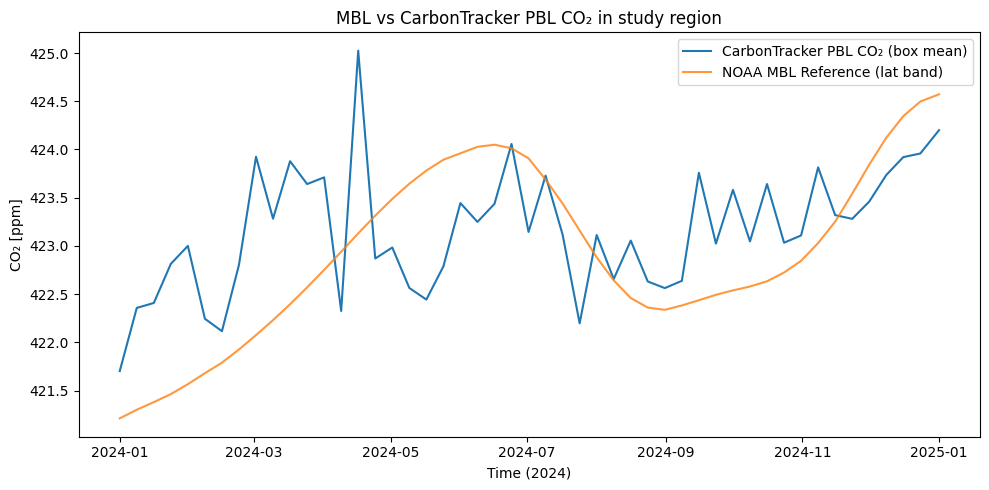

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(compare.index, compare["CT_PBL_CO2"], label="CarbonTracker PBL CO₂ (box mean)")
plt.plot(compare.index, compare["MBL_CO2"], label="NOAA MBL Reference (lat band)", alpha=0.8)
plt.ylabel("CO₂ [ppm]")
plt.xlabel("Time (2024)")
plt.legend()
plt.title("MBL vs CarbonTracker PBL CO₂ in study region")
plt.tight_layout()
plt.show()


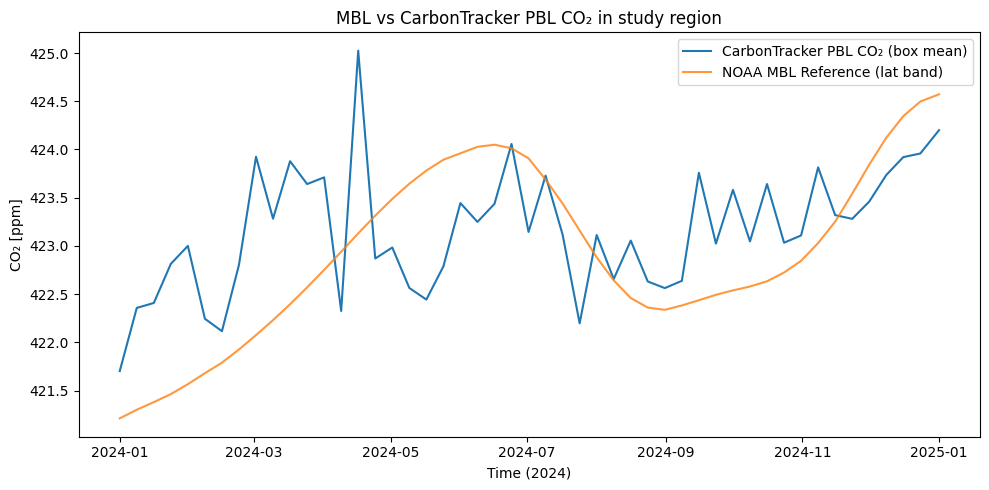

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(compare.index, compare["CT_PBL_CO2"], label="CarbonTracker PBL CO₂ (box mean)")
plt.plot(compare.index, compare["MBL_CO2"], label="NOAA MBL Reference (lat band)", alpha=0.8)
plt.ylabel("CO₂ [ppm]")
plt.xlabel("Time (2024)")
plt.legend()
plt.title("MBL vs CarbonTracker PBL CO₂ in study region")
plt.tight_layout()
plt.show()


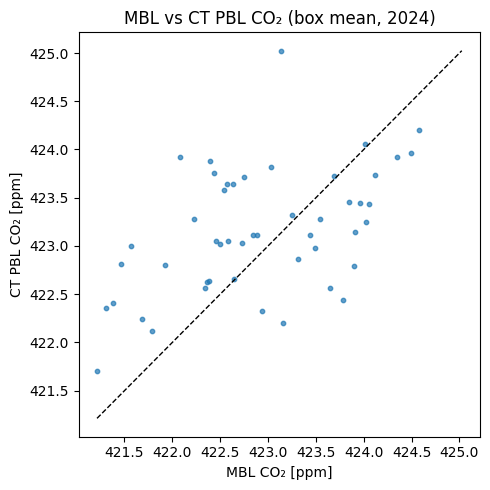

Mean CT - MBL [ppm]: 0.23466523
Std of difference [ppm]: 0.8130479


In [19]:
plt.figure(figsize=(5,5))
plt.scatter(compare["MBL_CO2"], compare["CT_PBL_CO2"], s=10, alpha=0.7)
min_val = min(compare.min())
max_val = max(compare.max())
plt.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1)  # 1:1 line

plt.xlabel("MBL CO₂ [ppm]")
plt.ylabel("CT PBL CO₂ [ppm]")
plt.title("MBL vs CT PBL CO₂ (box mean, 2024)")
plt.tight_layout()
plt.show()

# quick summary stats
diff = compare["CT_PBL_CO2"] - compare["MBL_CO2"]
print("Mean CT - MBL [ppm]:", diff.mean())
print("Std of difference [ppm]:", diff.std())


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from shapely.vectorized import contains

# --- names / variables ---
lat_name = "latitude"
lon_name = "longitude"
var_name = "pbl_co2"

pbl = ds[var_name]   # (time, latitude, longitude)

# weekly mean (Sunday-ending by default; you can change label/closed if you want)
pbl_weekly = pbl.resample(time="W").mean()  # result: (week, lat, lon)

# --- make sure area_gdf is in lon/lat ---
area_gdf = area_gdf.to_crs("EPSG:4326")
poly = unary_union(area_gdf.geometry)

lats = ds[lat_name].values
lons = ds[lon_name].values
lon2d, lat2d = np.meshgrid(lons, lats)

points = np.vstack([lon2d.ravel(), lat2d.ravel()]).T
mask_flat = contains(poly, points[:, 0], points[:, 1])
mask = mask_flat.reshape(lat2d.shape)   # (lat, lon)


/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_13359/1542259711.py:25: DeprecationWarning: The 'shapely.vectorized.contains' function is deprecated and will be removed a future version. Use 'shapely.contains_xy' instead (available since shapely 2.0.0).
  mask_flat = contains(poly, points[:, 0], points[:, 1])


In [21]:
def plot_ct_weekly_map(week_index, vmin=None, vmax=None):
    """
    week_index: integer index into pbl_weekly.time
    vmin, vmax: color scale limits (ppm)
    """
    da = pbl_weekly.isel(time=week_index)  # (lat, lon)
    t = pd.to_datetime(da["time"].item())

    data = da.values.copy()
    data[~mask] = np.nan  # keep only your polygon region

    # choose nice defaults for color limits if not supplied
    if vmin is None:
        vmin = np.nanpercentile(data, 2)
    if vmax is None:
        vmax = np.nanpercentile(data, 98)

    plt.figure(figsize=(6, 4))
    plt.pcolormesh(lons, lats, data, shading="auto", vmin=vmin, vmax=vmax)
    plt.colorbar(label="PBL CO$_2$ [ppm]")

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"CarbonTracker PBL CO$_2$ – weekly mean\nweek ending {t.date()}")
    plt.tight_layout()
    plt.show()


Number of weekly means: 53
time
2024-01-07   2024-01-07
2024-01-14   2024-01-14
2024-01-21   2024-01-21
2024-01-28   2024-01-28
2024-02-04   2024-02-04
Freq: W-SUN, Name: time, dtype: datetime64[ns]


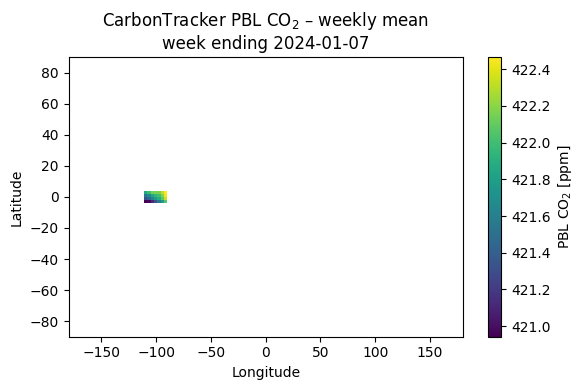

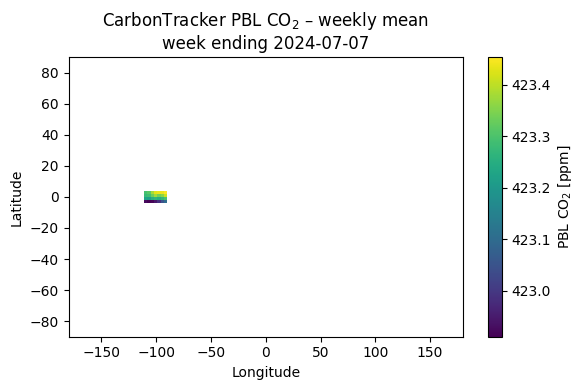

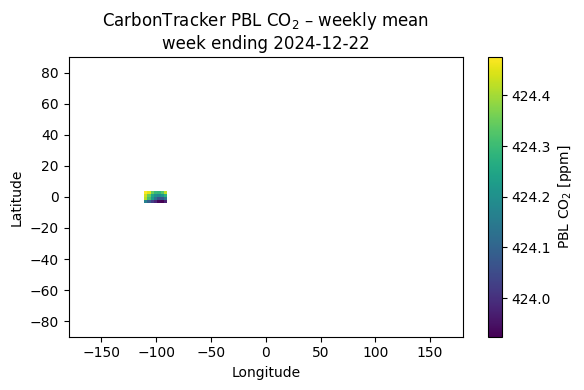

In [22]:
import pandas as pd

# how many weekly slices?
print("Number of weekly means:", pbl_weekly.sizes["time"])
print(pbl_weekly["time"].to_series().head())

# example: first week of the year
plot_ct_weekly_map(0)

# example: mid-year week (~week 26)
plot_ct_weekly_map(26)

# example: late-year week
plot_ct_weekly_map(50)


In [23]:
# CarbonTracker weekly box mean
# (you may already have pbl_area_mean from before; if not, recompute quickly)
pbl_region = pbl.where(mask)
pbl_area_mean = pbl_region.mean(dim=(lat_name, lon_name), skipna=True)
ct_ts = pbl_area_mean.to_series()
ct_ts.name = "CT_PBL_CO2"

ct_weekly = ct_ts.resample("W").mean()

# MBL weekly
mbl_weekly = mbl_ts.resample("W").mean()

# Align on common weeks
compare_weekly = pd.DataFrame({
    "CT_PBL_CO2": ct_weekly,
    "MBL_CO2": mbl_weekly,
}).dropna()

compare_weekly.head()


,CT_PBL_CO2,MBL_CO2
2024-01-07,421.819885,421.213348
2024-01-14,422.192657,421.302338
2024-01-21,422.442108,421.381653
2024-01-28,422.925232,421.464661
2024-02-04,422.935486,421.567657


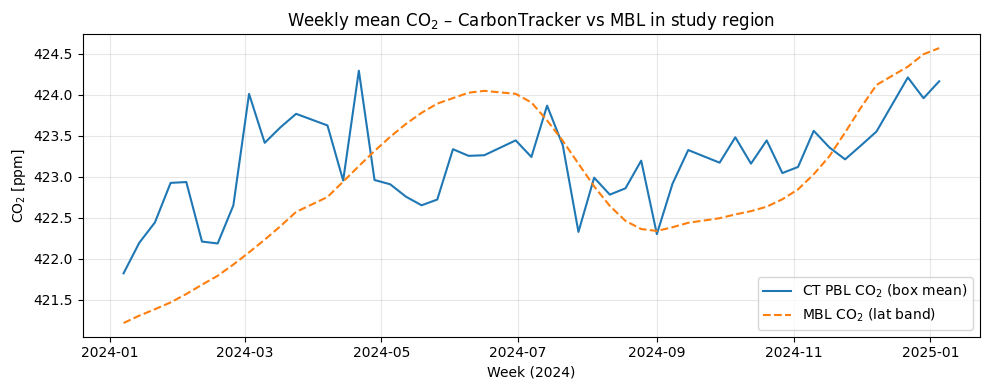

In [24]:
plt.figure(figsize=(10,4))
plt.plot(compare_weekly.index, compare_weekly["CT_PBL_CO2"], label="CT PBL CO$_2$ (box mean)")
plt.plot(compare_weekly.index, compare_weekly["MBL_CO2"], label="MBL CO$_2$ (lat band)", linestyle="--")

plt.ylabel("CO$_2$ [ppm]")
plt.xlabel("Week (2024)")
plt.title("Weekly mean CO$_2$ – CarbonTracker vs MBL in study region")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [25]:
minx, miny, maxx, maxy = area_gdf.total_bounds
print(minx, miny, maxx, maxy)


-110.0 -5.0 -90.0 5.0


In [26]:
def plot_ct_weekly_map(week_index, vmin=None, vmax=None):
    da = pbl_weekly.isel(time=week_index)
    t = pd.to_datetime(da["time"].item())

    # extract data & mask outside the polygon
    data = da.values.copy()
    data[~mask] = np.nan

    # choose nice color limits if not supplied
    if vmin is None:
        vmin = np.nanpercentile(data, 2)
    if vmax is None:
        vmax = np.nanpercentile(data, 98)

    plt.figure(figsize=(6,4))
    plt.pcolormesh(lons, lats, data, shading="auto", vmin=vmin, vmax=vmax)
    plt.colorbar(label="PBL CO$_2$ [ppm]")

    # 🔥 ZOOM IN HERE
    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"CT PBL CO₂ weekly mean – week ending {t.date()}")
    plt.tight_layout()
    plt.show()


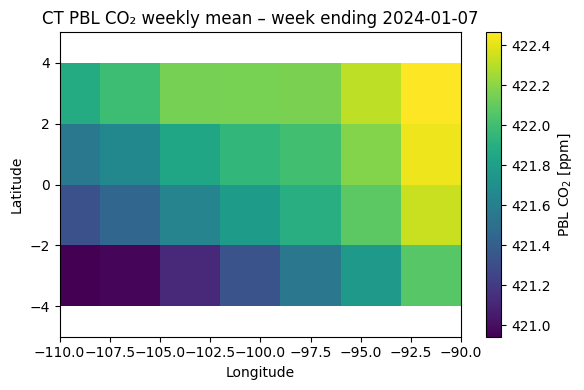

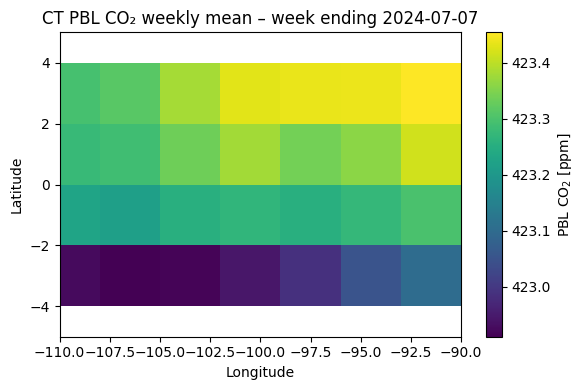

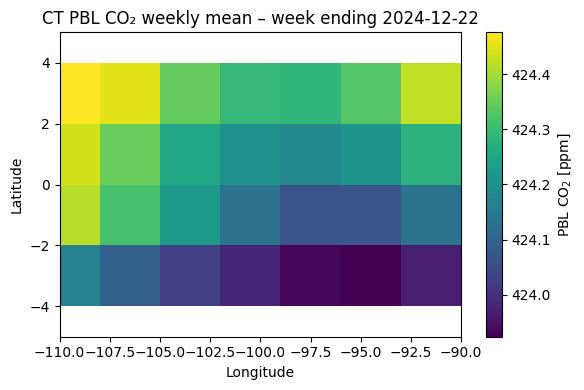

In [27]:
plot_ct_weekly_map(0)
plot_ct_weekly_map(26)
plot_ct_weekly_map(50)


In [28]:
import os

outdir = "ct_weekly_maps"
os.makedirs(outdir, exist_ok=True)

# pick global color limits so the GIF doesn't flicker
vmin = float(pbl_weekly.quantile(0.02).values)
vmax = float(pbl_weekly.quantile(0.98).values)

for i in range(len(pbl_weekly.time)):
    da = pbl_weekly.isel(time=i)
    t = pd.to_datetime(da["time"].item())
    fname = f"{outdir}/week_{i:02d}_{t.date()}.png"

    plt.figure(figsize=(6,4))
    data = da.values.copy()
    data[~mask] = np.nan
    plt.pcolormesh(lons, lats, data, shading="auto", vmin=vmin, vmax=vmax)
    plt.colorbar(label="PBL CO$_2$ [ppm]")

    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)

    plt.title(f"CT PBL CO₂ weekly\nending {t.date()}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.close()

print("Saved weekly maps in:", outdir)


Saved weekly maps in: ct_weekly_maps


In [31]:
import imageio
import glob

pngs = sorted(glob.glob("ct_weekly_maps/*.png"))

gif_frames = []
for f in pngs:
    gif_frames.append(imageio.imread(f))

imageio.mimsave("ct_weekly_co2.gif", gif_frames, duration=0.4)  # 0.4 sec per frame


/var/folders/5c/rc9sblr11n575rm6khzlpqkw0000gp/T/ipykernel_13359/506811611.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gif_frames.append(imageio.imread(f))


In [30]:
!pip install imageio